# <font size="5">Object Detection Model (Faster R-CNN)</font>

### Classification vs. Detection
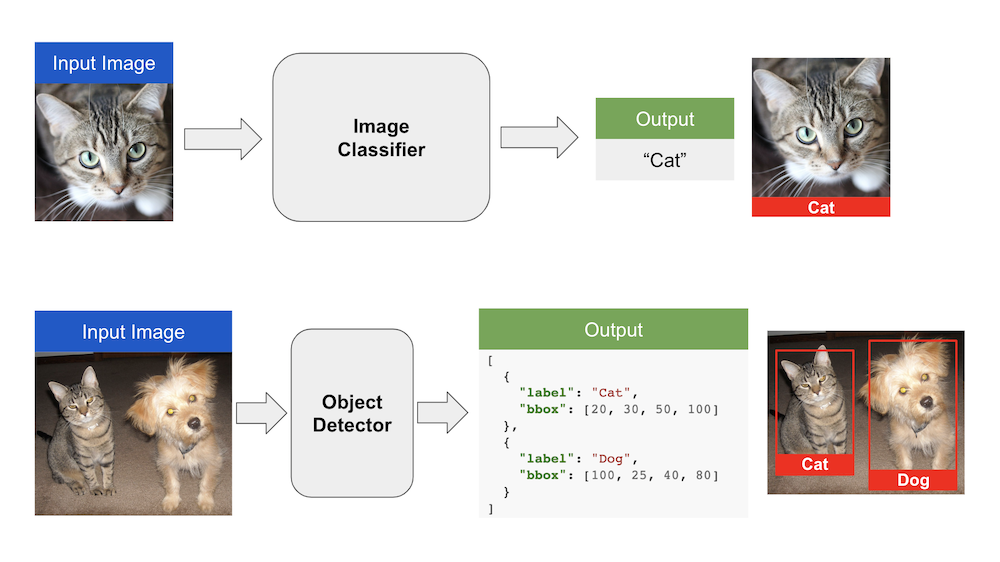

### Faster R-CNN Object Detector Overview

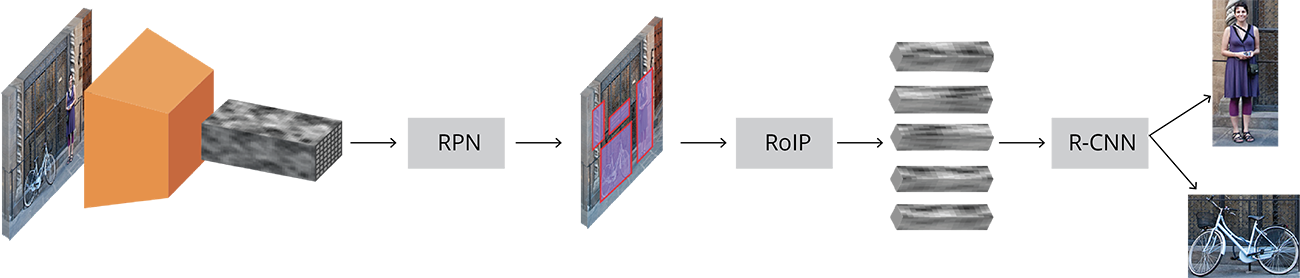

#### The Faster R-CNN works as follows:

* The RPN generates region proposals.
* For all region proposals in the image, a fixed-length feature vector is extracted from each region using the ROI Pooling layer 
* The extracted feature vectors are then classified using the Fast R-CNN.
* The class scores of the detected objects in addition to their bounding-boxes are returned.

# <font size="5">Object Detection using FasterRCNN Model (Pre-trained)</font>

#### Importing required python libraries

Missing python libraries can be installed using the following syntax: !pip install [packagename]

This code also uses reference functions that do not belong to any specific python library. They are present in the files:
* transforms.py (different from the transforms function from torchvision library)
* utils.py
* Both these can be download from here --> https://github.com/pytorch/vision/tree/main/references/detection
* Download these files and place them in the same location as this jupyter notebook

In [1]:
import torchvision.transforms as transforms
import cv2
import numpy
import numpy as np
import torchvision
import torch
torch.cuda.empty_cache()
import argparse
import cv2
from PIL import Image
import json
import random
import math
import sys
import os
from pycocotools.coco import COCO
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from matplotlib import pyplot as plt

import os
import utils


import transforms as T
 

### Getting Images and Annotations 

#### FIFTYONE: The open-source tool for building high-quality datasets and computer vision models.

FiftyOne provides the building blocks for optimizing your dataset analysis pipeline. Use it to get hands-on with your data, including visualizing complex labels, evaluating your models, exploring scenarios of interest, identifying failure modes, finding annotation mistakes, and much more!

#### COCO dataset can now be downloaded from FiftyOne Dataset Zoo:

Additional information can be found here: https://voxel51.com/docs/fiftyone/api/fiftyone.zoo.datasets.html

#### CoCo dataset output classes:

* Coco dataset set contains the following 91 classes as output.

* Certain classes have been removed from the 2017 version of the CoCo dataset and hence the "N/A" class.

* Additional information can be found here: https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/


In [2]:
coco_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


#### Defining Required functions

* predict(): This function uses a trained object detection model to generate bounding boxes, class labels and their confidence scores for a given input image. Values of the detection_treshold can be changed from 0 to 1. A 0.8 threshold value will result in bounding box predictions with greater than 80% confidence

* draw_boxes(): This function will overlay the bounding box prediction over an input image.


In [3]:

def predict(image, model, device, detection_threshold):
    # transform the image to tensor
    image = transform(image).to(device)
    image = image.unsqueeze(0) # add a batch dimension
    outputs = model(image) # get the predictions on the image
    # print the results individually
    # print(f"BOXES: {outputs[0]['boxes']}")
    # print(f"LABELS: {outputs[0]['labels']}")
    # print(f"SCORES: {outputs[0]['scores']}")
    # get all the predicited class names
    pred_classes = [coco_names[i] for i in outputs[0]['labels'].cpu().numpy()]
    # get score for all the predicted objects
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    # get all the predicted bounding boxes
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    # get boxes above the threshold score
    boxes = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32)
    return boxes, pred_classes, outputs[0]['labels']

def draw_boxes(boxes, classes, labels, image):
    # read the image with OpenCV
    image = cv2.cvtColor(np.asarray(image), cv2.COLOR_BGR2RGB)
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[i], (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                    lineType=cv2.LINE_AA)
    return image

In [4]:
# Create a different color for each class for efficient visualization
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))

# Define the torchvision image transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

### Generating results using a pre-trained model

In [5]:
# Providing required directory details

inputDir = "./input/"
outputDir = "./output/"
FinalModelLoc = "./model/"

inputImgs = os.listdir(inputDir)

# Selecting G.P.U device for faster execution
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Download pre-trained model
minInputSize = 512
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, min_size=minInputSize)
model.eval().to(device)

# Save the model for future use

torch.save(model,FinalModelLoc+"Pre-Trained_FasterRCNN.pth")

#Generate object detection results and save them in an output folder
for inputImg in inputImgs[:]:
    
    image = Image.open(inputDir+inputImg)
    
    boxes, classes, labels = predict(image, model, device, 0.8)
    outputImage = draw_boxes(boxes, classes, labels, image)
    #cv2.imshow('Image', image)
    cv2.imwrite(outputDir+inputImg+".jpg", outputImage)


c:\users\ambek\appdata\local\programs\python\python36\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# <font size="5">Object Detection using FasterRCNN Model (Non Pre-trained)</font>

#### Here we will train a Faster R-CNN model using custom images dowloaded from 'fiftyone.zoo.load_zoo_dataset' 

In [6]:
# Function to convert list of lists to a sinlge list.
#Eg: [[1,2,3], [4,5], [6]] --> [1,2,3,4,5,6]

def flattenList(inputList):
    flatList = []
    # Iterate over all the elements in the given list
    for elem in inputList:
        # Check if type of element is list
        if isinstance(elem, list):
            # Extend the flat list by adding contents of this element (list)
            flatList.extend(flattenList(elem))
        else:
            # Append the elemengt to the list
            flatList.append(elem)    
    return flatList

In [7]:
# Setting up the root directory for the training data
root = "./coco-2017/"

# Input directory containing the annotation file
annFile = root+"train/labels.json"

# Loading annotation into memory using the COCO library function
coco=COCO(annFile)


# Get the category id from label.json file
categorySelect = ['person']
cat_ids = coco.getCatIds(catNms=categorySelect)

# Get details of all images with the specific catgory in the cat_ids variable
imgIds = coco.getImgIds(catIds=cat_ids);

allimgMetadata = coco.loadImgs(imgIds)


if len(categorySelect) > 1: 
    for i in range(len(cat_ids)):
        imgIds.append(coco.getImgIds(catIds=cat_ids[i]));
        oneCatimgId = coco.getImgIds(catIds=cat_ids[i])
        print("Total images for the Category --> "+coco_names[cat_ids[i]]+" : "+ str(len(oneCatimgId)))
    imgIds = flattenList(imgIds)
    print("Total images for all Categories --> "+coco_names[cat_ids[i]]+" : "+ str(len(imgIds)))
else:
    for i in range(len(cat_ids)):
        imgIds = coco.getImgIds(catIds=cat_ids[i]);
        print("Total images for the Category --> "+coco_names[cat_ids[i]]+" : "+ str(len(imgIds)))
        


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Total images for the Category --> person : 51



#### Setting up our CoCo dataset classes and functions

The functions defined in the CoCoDataset() class does the following:
* Imports images that will be used in the model.
* Imports annotation.json (ground truth) file which contain the bounding box coordinates, class labels.
* Applies appropriate tranformations to the training set with the help of the RandomHorizontalFlip class and get_augmentation function, these augmentation usually helps prevent overfitting of the model.
* Returns transformed training images along with their ground truth.


In [8]:
class CoCoDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "data/"))))

 
    def __getitem__(self, idx):
        # load images and get bbox details
        # load images based on their image_id from labels.json
        
        global imgIds
        allimgMetadata = coco.loadImgs(imgIds)      
        
        boxes = []
        labels = []
        
        oneImgMetadata = allimgMetadata[idx]

        anns_ids = coco.getAnnIds(imgIds=oneImgMetadata['id'], catIds=cat_ids, iscrowd=None)

        anns = coco.loadAnns(anns_ids)

        bbox = anns[0]['bbox']

        xmin = np.float(bbox[0])
        ymin = np.float(bbox[1])
        xmax = np.float(bbox[0] + bbox[2])
        ymax = np.float(bbox[1] + bbox[3])

        boxes.append([xmin, ymin, xmax, ymax])

        imagename = oneImgMetadata["file_name"]

        labels.append(anns[0]['category_id'])

        img_path = self.root+"data/"+imagename
            

        img = Image.open(img_path).convert("RGB") 
        
        """
        # Code snippet to extract bounding box ROIs from images
        boxedimg = numpy.array(img)
        singleBOX = boxes[idx]
        x,y,x_w,y_h = int(singleBOX[0]), int(singleBOX[1]), int(singleBOX[2]), int(singleBOX[3])
        boxedimg = boxedimg[y:y_h, x:x_w]
        cv2.imwrite("./roi/"+str([idx])+".png",boxedimg)
        """
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)       

        im2tarIndex = torch.as_tensor(idx, dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        
        if self.transforms is not None:
            # Note that target (including bbox) is also transformed\enhanced here, which is different from transforms from torchvision
            img, target = self.transforms(img, target)
      
        return img, target
 
    def __len__(self):
        return len(self.imgs)
    
class RandomHorizontalFlip(object):
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
        return image, target

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        # 50% chance of flipping horizontally
        transforms.append(T.RandomHorizontalFlip(0.5))
 
    return T.Compose(transforms)

In [9]:
# Defining additional functions to help with the training process

def get_object_detection_model(num_classes):
    
    # load an object detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # replace the classifier with a new one, that has num_classes which is user-defined
    num_classes = 3
 
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
 
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
 
    return model


def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler=None):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )
         

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        #print(images[0].shape, targets[0])
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger


### Training a Faster R-CNN Model

In [10]:

# Project directiry containing training images and ground truth files
root = "./coco-2017/"
FinalModelLoc = "./model/"

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device =  torch.device('cpu')

num_classes = 2
# use our dataset and defined transformations
dataset = CoCoDataset(root+"train/", get_transform(train=False))
dataset_test = CoCoDataset(root+"train/", get_transform(train=False))

# Split the dataset in train and test set.

indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-15])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-15:])

# Define training and test data loaders

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, # num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, # num_workers=4,
    collate_fn=utils.collate_fn)


# get the model using our helper function
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, progress=True, num_classes=num_classes, pretrained_backbone=True)  # Or get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]

# SGD
optimizer = torch.optim.SGD(params, lr=0.0003,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler
# cos learning rate
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2)

# let's train it for   epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    # Engine.pyTrain_ofOne_The epoch function takes both images and targets. to(device)
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)

    # update the learning rate
    lr_scheduler.step()

    # evaluate on the test dataset    
    #evaluate(model, data_loader_test, device=device)    
    
print('')
print('==================================================')
print('Model saved')
print('==================================================')
    
torch.save(model,FinalModelLoc+"FasterRCNN.pth")

print("All Done!")

Epoch: [0]  [ 0/36]  eta: 0:00:27  lr: 0.000009  loss: 1.4389 (1.4389)  loss_classifier: 0.7371 (0.7371)  loss_box_reg: 0.0078 (0.0078)  loss_objectness: 0.6913 (0.6913)  loss_rpn_box_reg: 0.0027 (0.0027)  time: 0.7742  data: 0.0080  max mem: 1175
Epoch: [0]  [35/36]  eta: 0:00:00  lr: 0.000300  loss: 1.0664 (1.2204)  loss_classifier: 0.3730 (0.5162)  loss_box_reg: 0.0003 (0.0081)  loss_objectness: 0.6750 (0.6821)  loss_rpn_box_reg: 0.0050 (0.0141)  time: 0.2330  data: 0.0063  max mem: 1660
Epoch: [0] Total time: 0:00:08 (0.2496 s / it)
Epoch: [1]  [ 0/36]  eta: 0:00:08  lr: 0.000300  loss: 0.9753 (0.9753)  loss_classifier: 0.2445 (0.2445)  loss_box_reg: 0.0001 (0.0001)  loss_objectness: 0.6623 (0.6623)  loss_rpn_box_reg: 0.0684 (0.0684)  time: 0.2395  data: 0.0081  max mem: 1660
Epoch: [1]  [35/36]  eta: 0:00:00  lr: 0.000300  loss: 0.4847 (0.6637)  loss_classifier: 0.0461 (0.1152)  loss_box_reg: 0.0045 (0.0180)  loss_objectness: 0.4426 (0.5157)  loss_rpn_box_reg: 0.0052 (0.0147)  tim

### Testing Faster R-CNN Model

In [12]:
# Use the trained model, generate results and save them in an output folder
outputDir = "./output/"

model = torch.load(FinalModelLoc+'FasterRCNN.pth')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.eval().to(device)

for i in range(len(dataset_test)):
    
    img, _ = dataset_test[i]
    tran = transforms.ToPILImage()
    PILimg = tran(img)
    
    boxes, classes, labels = predict(PILimg, model, device, 0.8)
    outputImage = draw_boxes(boxes, classes, labels, PILimg)
    #cv2.imshow('Image', image)
    cv2.imwrite(outputDir+"/ObjectDetect_"+str(i)+".jpg", outputImage)
    


### References:

* https://arxiv.org/abs/1506.01497

* https://debuggercafe.com/faster-rcnn-object-detection-with-pytorch/

* https://programmer.group/train-your-faster-rcnn-target-detection-model-using-pytorch.html

* https://learnopencv.com/faster-r-cnn-object-detection-with-pytorch/

* https://tryolabs.com/blog/2018/01/18/faster-r-cnn-down-the-rabbit-hole-of-modern-object-detection

* https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/

* https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/